In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Hi everyone, this time I'm going to analyze a synthetic financial dataset generated by the PaySim mobile money simulator. This dataset simulates transactions based on real financial logs from a mobile money service operating in an African country.

The dataset contains 6 million transactions that took place over the span of 30 days, with each row representing a single transaction. The main objective is to create a supervised Machine Learning model to detect fraudulent activities based on historical transaction patterns.

The dataset includes the following important features:
1. **step**: maps a unit of time in the real world. In this case, 1 step is 1 hour of time. Total steps 744 (30 days simulation), **for example step 24 is equivalent to one day**.
2. **type**: types of transaction such as CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.
3. **amount**: the amount of the transaction in local currency.
4. **nameOrig**: ID of the sender (originator).
5. **oldbalanceOrg** & **newbalanceOrig**: sender's balance before and after a transaction.
6. **nameDest**: ID of the Recipient.
7. **oldbalanceDest** & **newbalanceDest**: recipient's balance before and after a transaction. **i**
8. **isFraud**: `isFraud = 1` indicates a fraudulent transaction and 0 if otherwise. **ii**
9. **isFlaggedFraud**: Indicates whether the system flagged the transaction as potentially fraudulent (1 if flagged while 0 if otherwise). **iii**

**i**. Note that there is no information for initial and new balance of customers that start with **M (Merchants)**.

**ii**. The fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**iii**. The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## I. INSTALL LIBRARIES

Please install all required packages if not already available.

In [7]:
!pip install optuna xgboost lightgbm catboost imbalanced-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.1 MB/s eta 0:00:00


In [10]:
!pip install optuna-integration[xgboost,lightgbm,catboost] imbalanced-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


## II. IMPORT AND LOAD DATASET

The dataset is a CSV file with file size > 100 MB, therefore it could not be uploaded to GitHub. I decided to upload it inside my Google Drive and import it using drive.mount to be uploaded on the notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/Google Colab Notebooks/Data Analysis and AI Portfolio/Detecting Fraudulent Transactions (synthetic)/PS_201~1.CSV'

In [4]:
# Load mobile money transactions dataset into the notebook
import pandas as pd
df = pd.read_csv(file_path)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.ticker import FuncFormatter, ScalarFormatter

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, precision_recall_curve, roc_curve, auc

from imblearn.over_sampling import SMOTE

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier

from optuna.integration import (
    XGBoostPruningCallback,
    CatBoostPruningCallback,
    LightGBMPruningCallback
)

import joblib
import time

In [ ]:
# Display the first 5 rows of the transactions dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Rename newbalanceOrig into newbalanceOrg
df.rename(columns={'newbalanceOrig': 'newbalanceOrg'}, inplace=True)

# Rename nameOrig into nameOrg
df.rename(columns={'nameOrig': 'nameOrg'}, inplace=True)

In [ ]:
# Get all column names from the dataset
col_names = df.columns

# Display column names
col_names

Index(['step', 'type', 'amount', 'nameOrg', 'oldbalanceOrg', 'newbalanceOrg',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrg         object 
 4   oldbalanceOrg   float64
 5   newbalanceOrg   float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


(6362620, 11)

In [ ]:
# Show statistical summary of numerical features with 2 decimal rounding without scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
step,6362620.00,243.40,142.33,1.00,156.00,239.00,335.00,743.00
amount,6362620.00,179861.90,603858.23,0.00,13389.57,74871.94,208721.48,92445516.64
oldbalanceOrg,6362620.00,833883.10,2888242.67,0.00,0.00,14208.00,107315.18,59585040.37
newbalanceOrg,6362620.00,855113.67,2924048.50,0.00,0.00,0.00,144258.41,49585040.37
oldbalanceDest,6362620.00,1100701.67,3399180.11,0.00,0.00,132705.66,943036.71,356015889.35
newbalanceDest,6362620.00,1224996.40,3674128.94,0.00,0.00,214661.44,1111909.25,356179278.92
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


## III. DATA EXPLORATION & PREPARATION

**In this part, I'm going to explore the data, visualize data distribution, identify any missing values, check for any duplicated values, and handling outliers. I might also need to do some feature engineering to help the model during fraud detection training process.**

In [ ]:
# Count and display occurrences of LEGITIMATE and FRAUD transactions (0=normal, 1=fraud)
print(df["isFraud"].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [ ]:
# Show percentage distribution of LEGITIMATE and FRAUD transactions
(df["isFraud"].value_counts(normalize=True)* 100).round(4)

isFraud
0   99.87
1    0.13
Name: proportion, dtype: float64

**There are 6,354,407 (99,87%) legitimate transactions and 8,213 (0,13%) fraud transactions. The dataset is heavily imbalanced.**

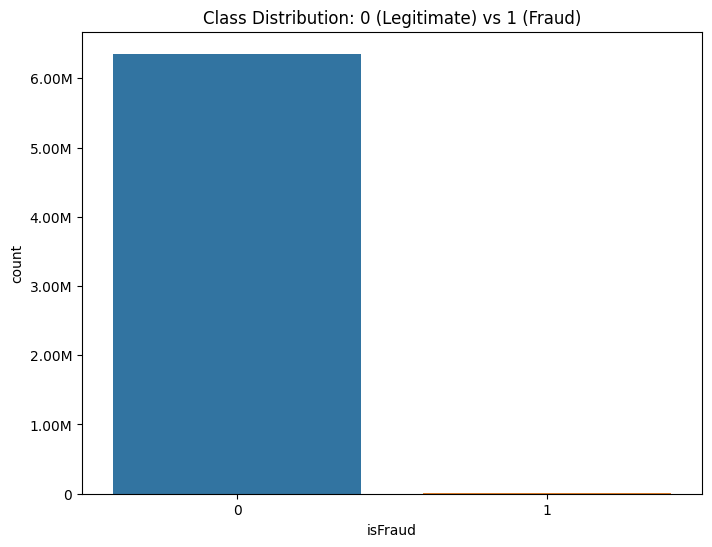

In [ ]:
# Distribution visualization of LEGITIMATE and FRAUD transactions using a bar chart
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'

    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(8,6))
sns.countplot(x="isFraud", data=df)
plt.title("Class Distribution: 0 (Legitimate) vs 1 (Fraud)")

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [ ]:
# Count and display occurrences of systematic FLAGGED transactions (0=normal, 1=fraud)
(df['isFlaggedFraud'].value_counts())

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [ ]:
# Show percentage distribution of systematic FLAGGED transactions
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
(df['isFlaggedFraud'].value_counts(normalize=True) * 100).round(4)

isFlaggedFraud
0   99.9997
1    0.0003
Name: proportion, dtype: float64

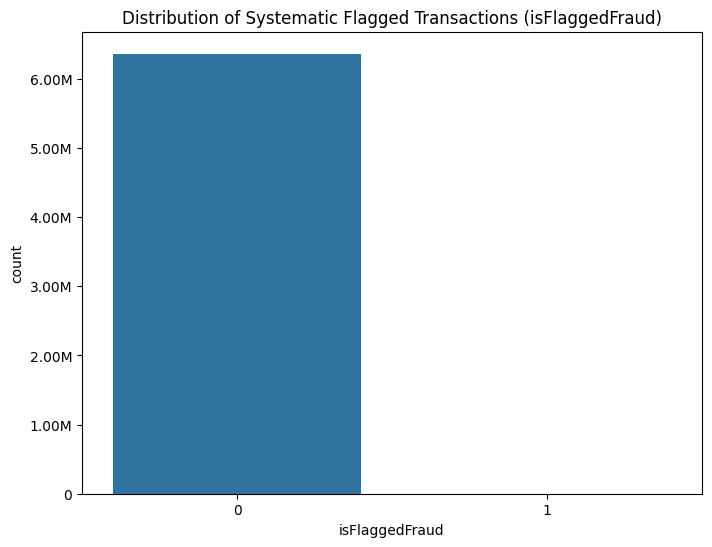

In [ ]:
# Distribution visualization of systematic FLAGGED transactions using a bar chart
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'

    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(8,6))
sns.countplot(x="isFlaggedFraud", data=df)
plt.title("Distribution of Systematic Flagged Transactions (isFlaggedFraud)")

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)

plt.show()

In [ ]:
# Count and display the distribution of TYPES of financial transactions
print(df["type"].value_counts())

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [ ]:
# Show percentage distribution of TYPES of financial transactions
df["type"].value_counts(normalize=True)

type
CASH_OUT   0.3517
PAYMENT    0.3381
CASH_IN    0.2199
TRANSFER   0.0838
DEBIT      0.0065
Name: proportion, dtype: float64

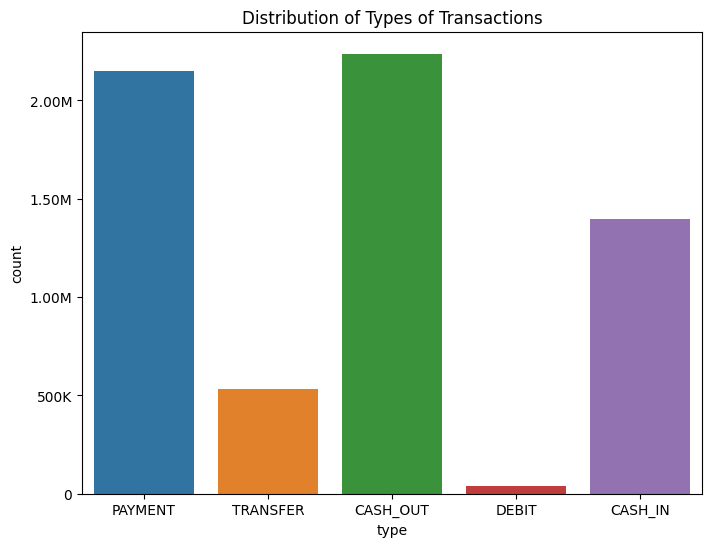

In [ ]:
# Distribution visualization of TYPES of financial transactions using a bar chart
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'

    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(8,6))
sns.countplot(x="type", data=df)
plt.title("Distribution of Types of Transactions")

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)

plt.show()

**There are 5 types of financial transactions inside the dataset which are as detailed as following:**
- CASH_OUT --> 2,237,500 (35.17%)
- PAYMENT --> 2,151,495 (33.81%)
- CASH_IN --> 1,399,284 (21.99%)
- TRANSFER --> 532,909 (8.34%)
- DEBIT --> 41,432 (0.65%)

In [ ]:
# Check the number of missing values in each column of the dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrg           0
oldbalanceOrg     0
newbalanceOrg     0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
# Show all rows that are duplicates (keeping and showing all occurrences)
df[df.duplicated(keep=False)]

,step,type,amount,nameOrg,oldbalanceOrg,newbalanceOrg,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


**There are no missing and duplicated values in this dataset.**

Before I proceed to check data/values distribution and outliers further, I'm going to encode non-numerical feature like **type**.

In [ ]:
# Save the mapping from encoded numeric values to original category labels before encoding process
type_mapping_type = dict(enumerate(df['type'].astype('category').cat.categories))

In [ ]:
# Encode type as a non-numerical feature
df_encoded = df.copy()
df_encoded['type'] = df_encoded['type'].astype("category").cat.codes

In [ ]:
print(type_mapping_type)

{0: 'CASH_IN', 1: 'CASH_OUT', 2: 'DEBIT', 3: 'PAYMENT', 4: 'TRANSFER'}


In [ ]:
df_encoded.head()

,step,type,amount,nameOrg,oldbalanceOrg,newbalanceOrg,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.6400,C1231006815,170136.0000,160296.3600,M1979787155,0.0000,0.0000,0,0
1,1,3,1864.2800,C1666544295,21249.0000,19384.7200,M2044282225,0.0000,0.0000,0,0
2,1,4,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,1,181.0000,C840083671,181.0000,0.0000,C38997010,21182.0000,0.0000,1,0
4,1,3,11668.1400,C2048537720,41554.0000,29885.8600,M1230701703,0.0000,0.0000,0,0


**A. Feature Engineering**

In this part, I'm going to utilize the updated dataset (df_encoded) to do some feature engineering, but I'm going to keep the original df_encoded dataset intact and create a new one named df_feat_eng.

In [ ]:
# Create a copy of df_encoded so the next process won't change the original df_encoded
df_feat_eng = df_encoded.copy()

In [ ]:
# 1. Create a feature named diff_sender_balance from old & new balance of origin/sender
# To check the balance difference after transaction on sender accounts
df_feat_eng['diff_sender_balance'] = df_feat_eng['oldbalanceOrg'] - df_feat_eng['newbalanceOrg']

In [ ]:
# 2. Create a feature named diff_receiver_balance from old & new balance of destination/receiver
# To check the balance difference after transaction on receiver accounts
df_feat_eng['diff_receiver_balance'] = df_feat_eng['newbalanceDest'] - df_feat_eng['oldbalanceDest']

In [ ]:
# 3. Create a feature named sender_is_zero to identify accounts with 0 in their original balance
# To identify any sender accounts with 0 starting balance
# Sender accounts with 0 starting balance might be fake accounts
df_feat_eng['sender_is_zero'] = (df_feat_eng['oldbalanceOrg'] == 0).astype(int)

In [ ]:
# 4. Create a feature named receiver_is_zero to identify accounts with 0 in their original balance
# To identify any receiver accounts with 0 starting balance
# Receiver accounts with 0 starting balance might belong to fraudsters
df_feat_eng['receiver_is_zero'] = (df_feat_eng['oldbalanceDest'] == 0).astype(int)

In [ ]:
# 5. Create a feature named sender_is_drained
# If the sender balance is 0 after transaction, the funds might be syphoned by the fraudster
df_feat_eng['sender_is_drained'] = (df_feat_eng['newbalanceOrg'] == 0).astype(int)

In [ ]:
# 6. Create a fature named amount_to_balance_ratio
# Calculate the ratio of transaction amount to sender's original balance
# The higher the ratio, the more suspicious the transaction is
df_feat_eng['amount_to_balance_ratio'] = df_feat_eng['amount'] / (df_feat_eng['oldbalanceOrg'] + 1)

In [ ]:
df_feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   step                     int64  
 1   type                     int8   
 2   amount                   float64
 3   nameOrg                  object 
 4   oldbalanceOrg            float64
 5   newbalanceOrg            float64
 6   nameDest                 object 
 7   oldbalanceDest           float64
 8   newbalanceDest           float64
 9   isFraud                  int64  
 10  isFlaggedFraud           int64  
 11  diff_sender_balance      float64
 12  diff_receiver_balance    float64
 13  sender_is_zero           int64  
 14  receiver_is_zero         int64  
 15  sender_is_drained        int64  
 16  amount_to_balance_ratio  float64
dtypes: float64(8), int64(6), int8(1), object(2)
memory usage: 782.8+ MB


I'm going to to drop `nameDest` and `nameOrg` because of their values' uniqueness.

I'm also going to drop another 4 features such as, `oldbalanceOrg`,`newbalanceOrg`, `oldbalanceDest`, and `newbalanceDest` because they contain information that would not be available at the time of prediction.

These features reflect the account balances after the transaction happens, which could lead to data leakage and make the model unrealistically accurate.

In real life fraud detection, we want to predict fraud before a transaction is processed, not after.

In [ ]:
# Drop nameDest and nameOrg because of their values' uniqueness
df_clean = df_feat_eng.drop(columns=['nameOrg', 'nameDest',
                                    'oldbalanceOrg', 'newbalanceOrg',
                                    'oldbalanceDest', 'newbalanceDest'])

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   step                     int64  
 1   type                     int8   
 2   amount                   float64
 3   isFraud                  int64  
 4   isFlaggedFraud           int64  
 5   diff_sender_balance      float64
 6   diff_receiver_balance    float64
 7   sender_is_zero           int64  
 8   receiver_is_zero         int64  
 9   sender_is_drained        int64  
 10  amount_to_balance_ratio  float64
dtypes: float64(4), int64(6), int8(1)
memory usage: 491.5 MB


In [ ]:
df_clean.head()

,step,type,amount,isFraud,isFlaggedFraud,diff_sender_balance,diff_receiver_balance,sender_is_zero,receiver_is_zero,sender_is_drained,amount_to_balance_ratio
0,1,3,9839.6400,0,0,9839.6400,0.0000,0,1,0,0.0578
1,1,3,1864.2800,0,0,1864.2800,0.0000,0,1,0,0.0877
2,1,4,181.0000,1,0,181.0000,0.0000,0,1,1,0.9945
3,1,1,181.0000,1,0,181.0000,-21182.0000,0,0,1,0.9945
4,1,3,11668.1400,0,0,11668.1400,0.0000,0,1,0,0.2808


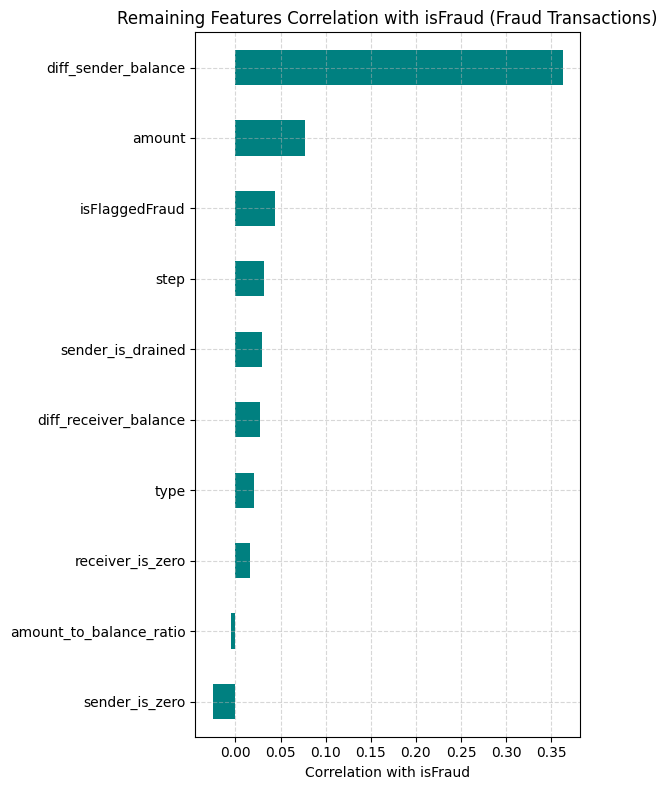

In [ ]:
# Correlation between the remaining features of df_clean and fraudulent transactions (isFraud)
correlations = df_clean.corr()["isFraud"].drop("isFraud").sort_values()

plt.figure(figsize=(6, 8))
correlations.plot(kind="barh", color="teal")

plt.title('Remaining Features Correlation with isFraud (Fraud Transactions)')
plt.xlabel('Correlation with isFraud')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Since there are no features with missing and duplicated values**, I'm going to create boxplots to visualize data/values distribution and outliers from selected features with both strong positive and strong negative correlation against isFraud variable.

**B. Values Distribution of each Feature against isFraud variable.**

In [ ]:
# Selected numerical features for data/values distribution visualization against isFraud variable
selected_numerical_features = ['diff_sender_balance', 'diff_receiver_balance',
                               'amount', 'amount_to_balance_ratio', 'step']

# Separation of features before standardization process
features_to_scale = [
    'diff_sender_balance',
    'diff_receiver_balance',
    'amount',
    'amount_to_balance_ratio'
]

features_not_scaled = [
    'isFlaggedFraud',
    'sender_is_drained',
    'sender_is_zero',
    'receiver_is_zero',
    'type',
    'step'
]

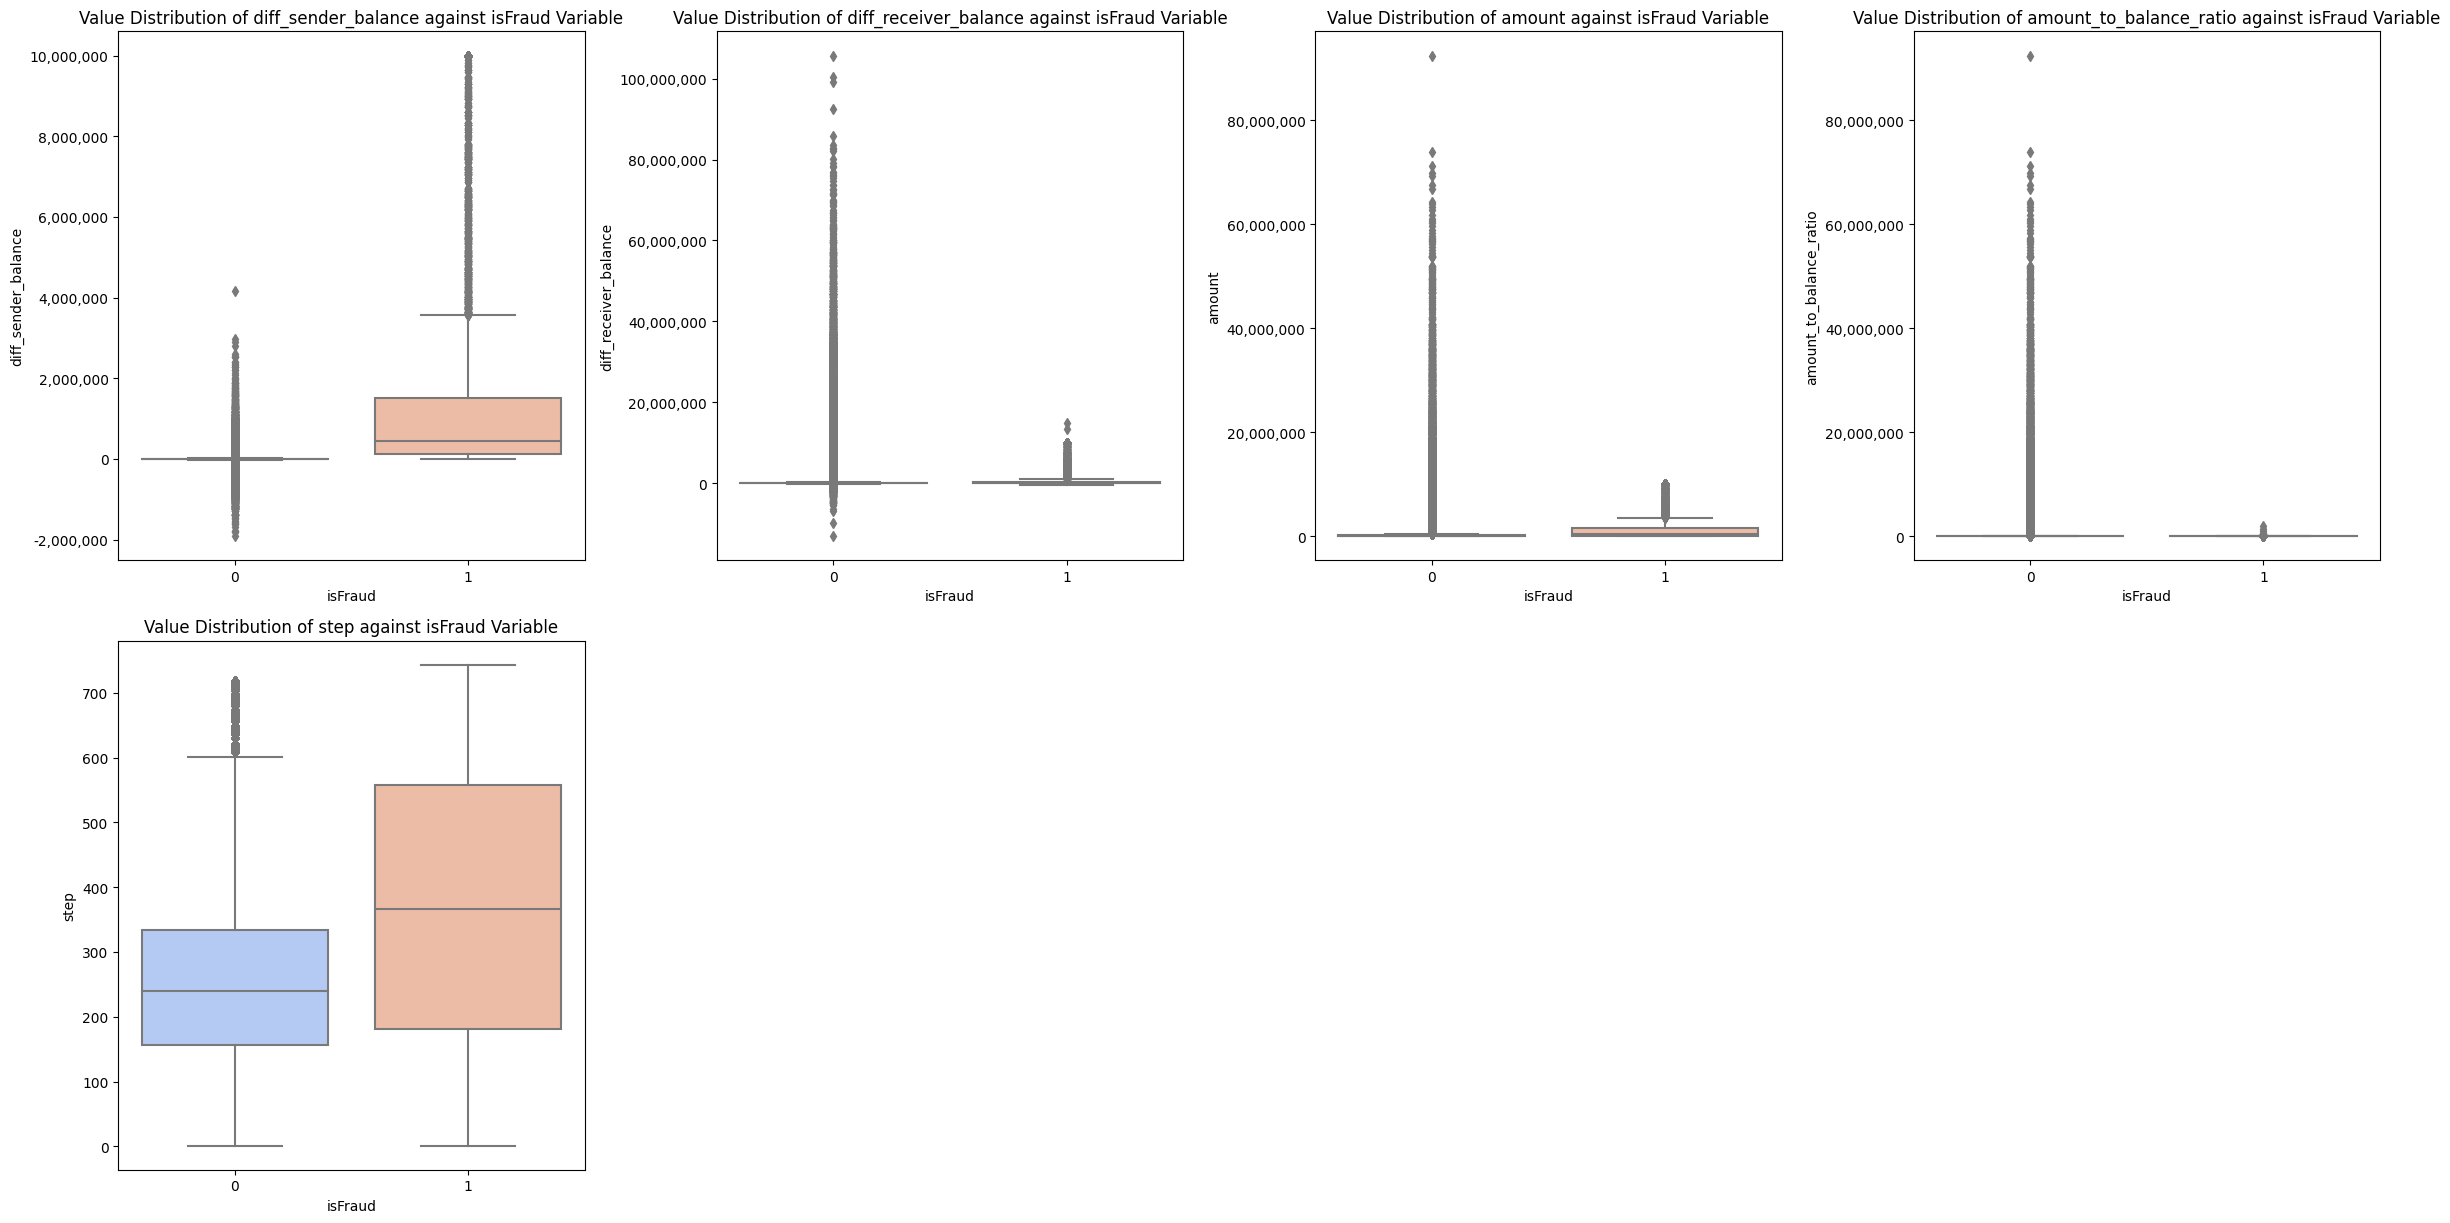

In [ ]:
# Visualization for values distribution for selected features against isFraud with boxplots

# y-axis formatter to eliminate scientific notation
def thousands_formatter(x, pos):
    return f'{int(x):,}'

plt.figure(figsize=(24, 18))
for i, feature in enumerate(selected_numerical_features, 1):
    ax = plt.subplot(3, 4, i)
    sns.boxplot(data=df_clean, x='isFraud', y=feature, palette='coolwarm')
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.title(f'Value Distribution of {feature} against isFraud Variable')

plt.tight_layout()
plt.show()

Below is an easier way to read and understand the statistics of boxplots above **(selected_numerical_features vs isFraud)**.

In [ ]:
df_clean[df_clean['isFraud'] == 1][selected_numerical_features].describe()

,diff_sender_balance,diff_receiver_balance,amount,amount_to_balance_ratio,step
count,8213.0000,8213.0000,8213.0000,8213.0000,8213.0000
mean,1457274.9739,735457.9981,1467967.2991,1161.9667,368.4139
std,2396099.2020,1856983.8560,2404252.9472,32297.1530,216.3887
min,0.0000,-315226.0700,0.0000,0.0000,1.0000
25%,124582.5800,0.0000,127091.3300,1.0000,181.0000
50%,436317.4900,0.0000,441423.4400,1.0000,367.0000
75%,1503034.8600,445257.4300,1517771.4800,1.0000,558.0000
max,10000000.0000,14915111.4700,10000000.0000,1933920.8000,743.0000


In [ ]:
df_clean[df_clean['isFraud'] == 0][selected_numerical_features].describe()

,diff_sender_balance,diff_receiver_balance,amount,amount_to_balance_ratio,step
count,6354407.0000,6354407.0000,6354407.0000,6354407.0000,6354407.0000
mean,-23141.5164,123504.8100,178197.0417,70764.3209,243.2357
std,106223.3015,810422.2721,596236.9813,508745.2590,142.1402
min,-1915267.9000,-13060826.2100,0.0100,0.0000,1.0000
25%,0.0000,0.0000,13368.3950,0.2334,156.0000
50%,0.0000,0.0000,74684.7200,6.5116,239.0000
75%,10102.1250,148982.6400,208364.7600,12355.5900,334.0000
max,4164236.3100,105687838.8200,92445516.6400,92445516.6400,718.0000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

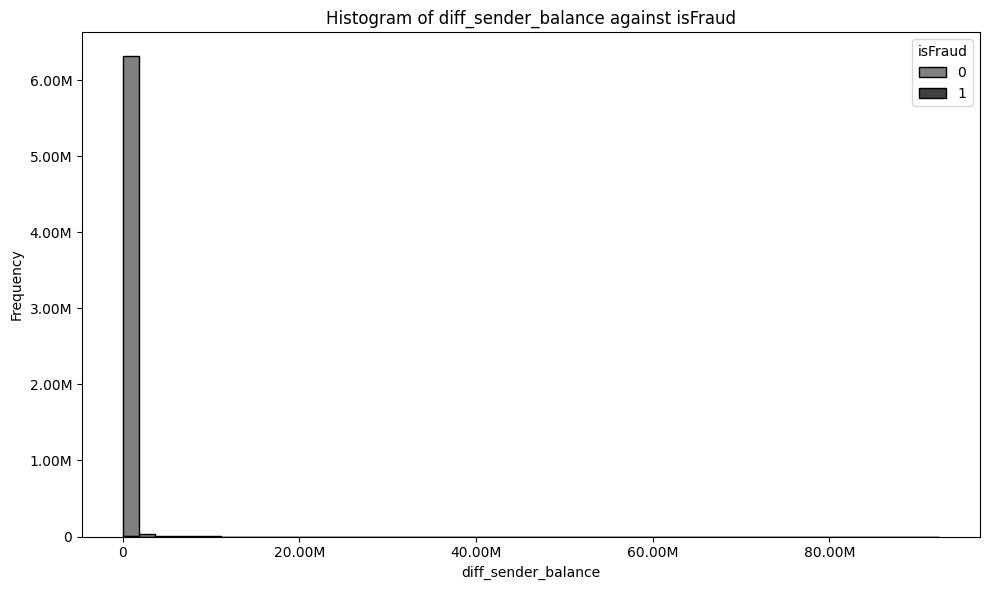

In [ ]:
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='amount',
    hue='isFraud',
    bins=50,
    palette={0: '#555555', 1: 'black'},
    multiple='stack',
    kde=False
)

plt.title('Histogram of diff_sender_balance against isFraud')
plt.xlabel('diff_sender_balance')
plt.ylabel('Frequency')

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

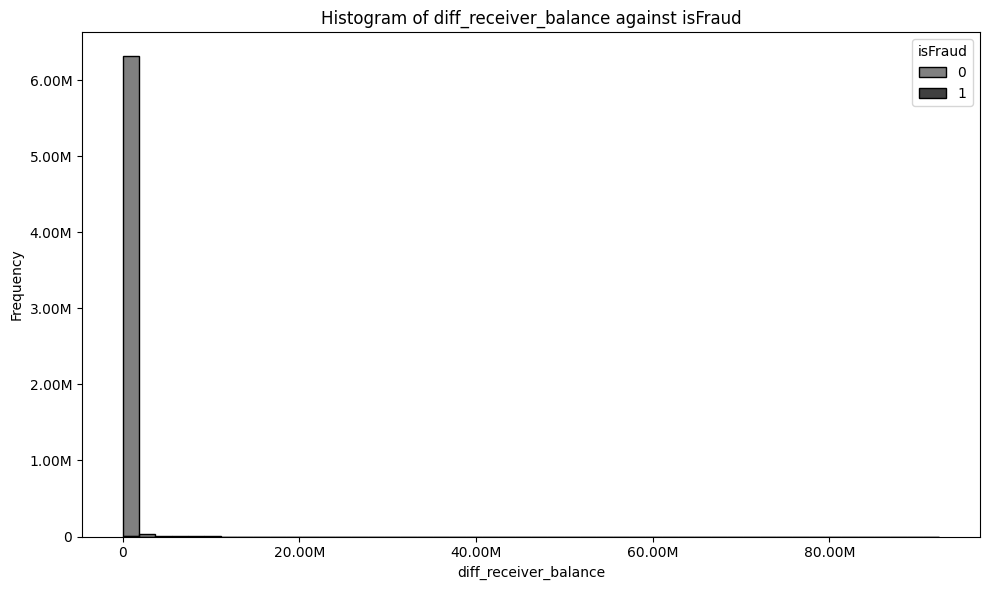

In [ ]:
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='amount',
    hue='isFraud',
    bins=50,
    palette={0: '#555555', 1: 'black'},
    multiple='stack',
    kde=False
)

plt.title('Histogram of diff_receiver_balance against isFraud')
plt.xlabel('diff_receiver_balance')
plt.ylabel('Frequency')

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

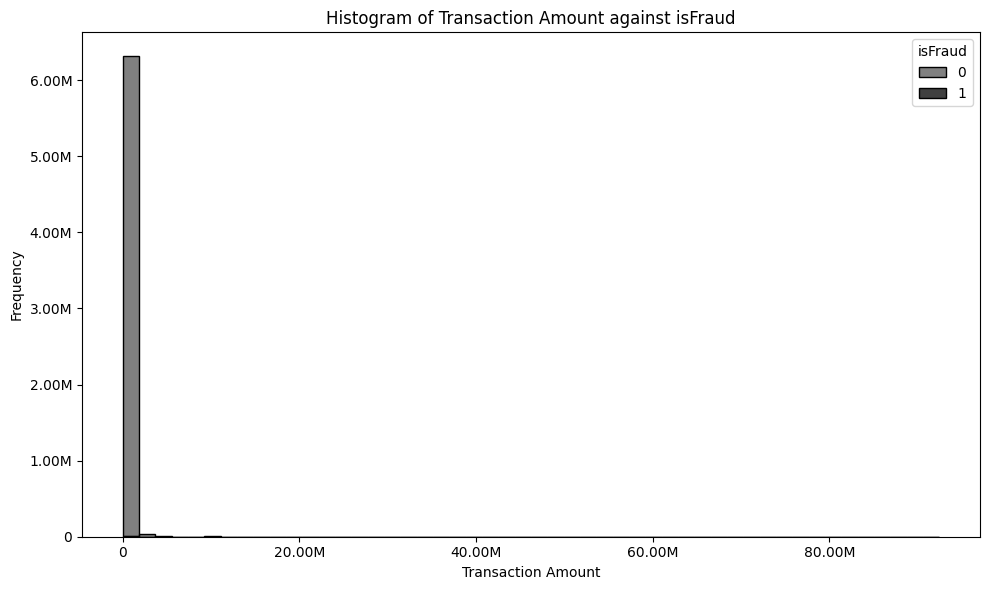

In [ ]:
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='amount',
    hue='isFraud',
    bins=50,
    palette={0: '#555555', 1: 'black'},
    multiple='stack',
    kde=False
)

plt.title('Histogram of Transaction Amount against isFraud')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

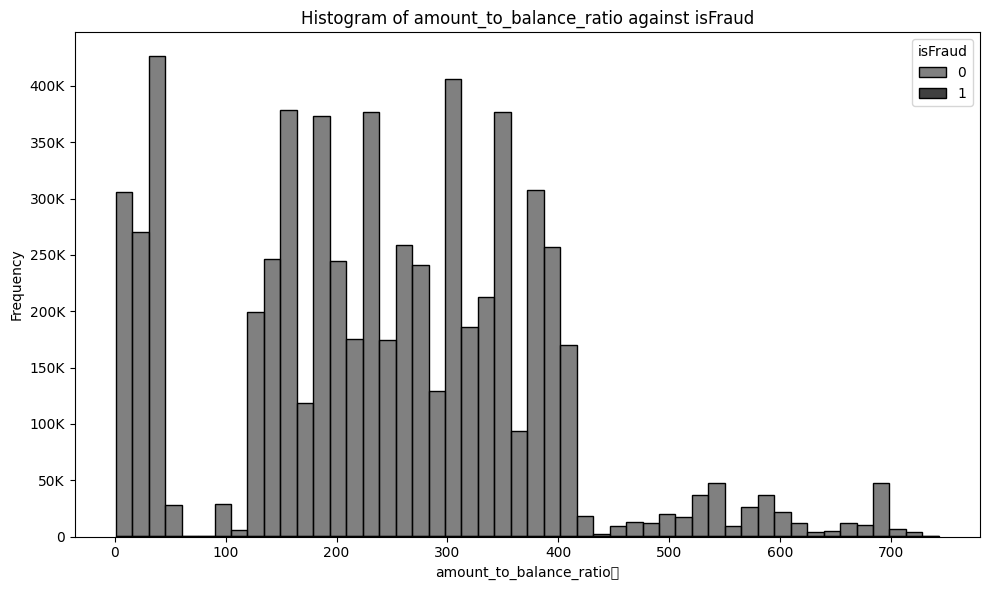

In [ ]:
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='step',
    hue='isFraud',
    bins=50,
    palette={0: '#555555', 1: 'black'},
    multiple='stack',
    kde=False
)

plt.title('Histogram of amount_to_balance_ratio against isFraud')
plt.xlabel('amount_to_balance_ratio	')
plt.ylabel('Frequency')

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

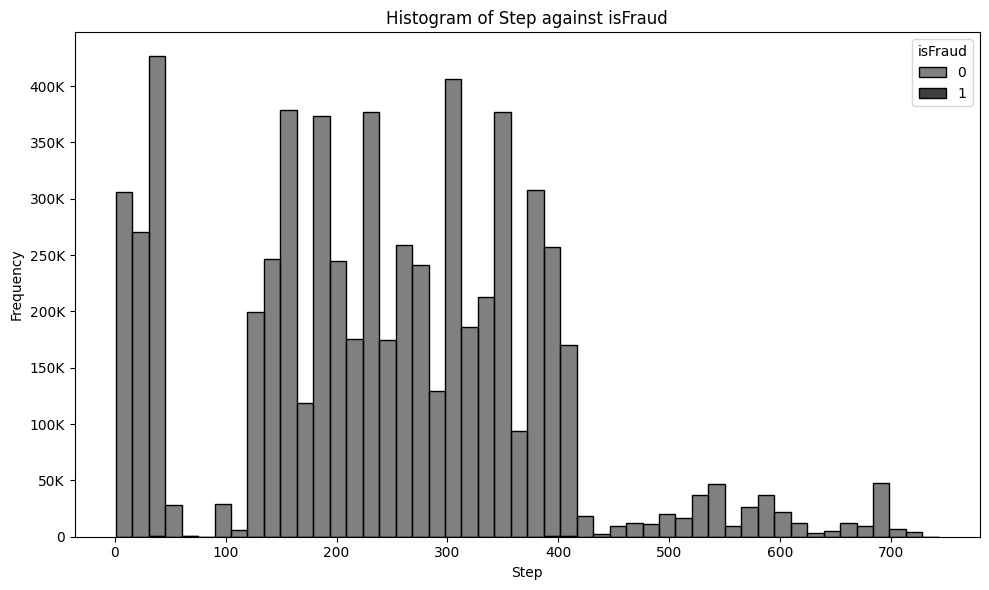

In [ ]:
def thousands_formatter(x, pos):
    abs_x = abs(x)
    if abs_x >= 1_000_000:
        formatted = f'{abs_x / 1_000_000:.2f}M'
    elif abs_x >= 1_000:
        formatted = f'{abs_x / 1_000:.0f}K'
    else:
        formatted = f'{int(abs_x)}'
    return f'-{formatted}' if x < 0 else formatted

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean,
    x='step',
    hue='isFraud',
    bins=50,
    palette={0: '#555555', 1: 'black'},
    multiple='stack',
    kde=False
)

plt.title('Histogram of Step against isFraud')
plt.xlabel('Step')
plt.ylabel('Frequency')

ax = plt.gca()
formatter = FuncFormatter(thousands_formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

**C. Outlier Identification of each Numerical Feature with IQR method.**

In [ ]:
# Selected numerical features for outlier detection and handling
selected_numerical_features = ['diff_sender_balance', 'diff_receiver_balance',
                               'amount', 'amount_to_balance_ratio', 'step']

In [ ]:
# Save outlier information
outlier_summary = []

# Utilize IQR method to detect any outliers
for feature in selected_numerical_features:
    Q1 = df_clean[feature].quantile(0.25)
    Q3 = df_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Boolean mask to determine and separate outliers
    outliers = df_clean[(df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)]

    # Outlier summary
    total = len(df_clean)
    outlier_count = len(outliers)
    percentage = (outlier_count / total) * 100

    outlier_summary.append({
        'Feature': feature,
        'Outlier Count': outlier_count,
        'Total Rows': total,
        'Percentage (%)': round(percentage, 2)
    })

# Convert the summary into a DataFrame
outlier_df = pd.DataFrame(outlier_summary)

# Display the number and percentage of detected outliers
print(outlier_df)

                   Feature  Outlier Count  Total Rows  Percentage (%)
0      diff_sender_balance        2139299     6362620         33.6200
1    diff_receiver_balance         886695     6362620         13.9400
2                   amount         338078     6362620          5.3100
3  amount_to_balance_ratio        1271316     6362620         19.9800
4                     step         102688     6362620          1.6100


**Rather than deleting or dropping outliers, I decided to try applying `Winsorization` on all outliers of each feature in this dataset**.

i. What is **Winsorization**?

It is a statistical technique to reduce the impact of extreme outliers by replacing the most extreme values (either low or high) with less extreme percentiles.


ii. **For example**, in a 90% Winsorization, the top 5% and bottom 5% of a dataset are capped at the 95th and 5th percentile values, respectively.


iii. **Keypoints**:

a. Unlike trimming *(deleting outliers)*, **Winsorization** retains all data points but 'clips' them.

b. It is common in machine learning, finance, and biostatistics to handle skewed data.


iv. **The goal** of this technique is to preserve data structure while making any analysis *(e.g. Logistic Regression & Random Forest)*  less sensitive to outliers.

In [ ]:
# Copy the data of df_clean to avoid modifying the original dataframe
df_winsorized = df_clean.copy()

In [ ]:
# List of features to apply 'winsorization' on
winsorize_features = ['diff_sender_balance', 'diff_receiver_balance',
                      'amount', 'amount_to_balance_ratio']

# Loop through each selected feature and apply winsorization (1% lower & 99% upper)
for col in winsorize_features:
    lower = df_winsorized[col].quantile(0.01)  # Lower threshold
    upper = df_winsorized[col].quantile(0.99)  # Upper threshold
    df_winsorized[col] = np.clip(df_winsorized[col], lower, upper) # Replace values outside thresholds with the boundary values

print('Winsorization process completed for selected numerical features!')

Winsorization process completed for selected numerical features!


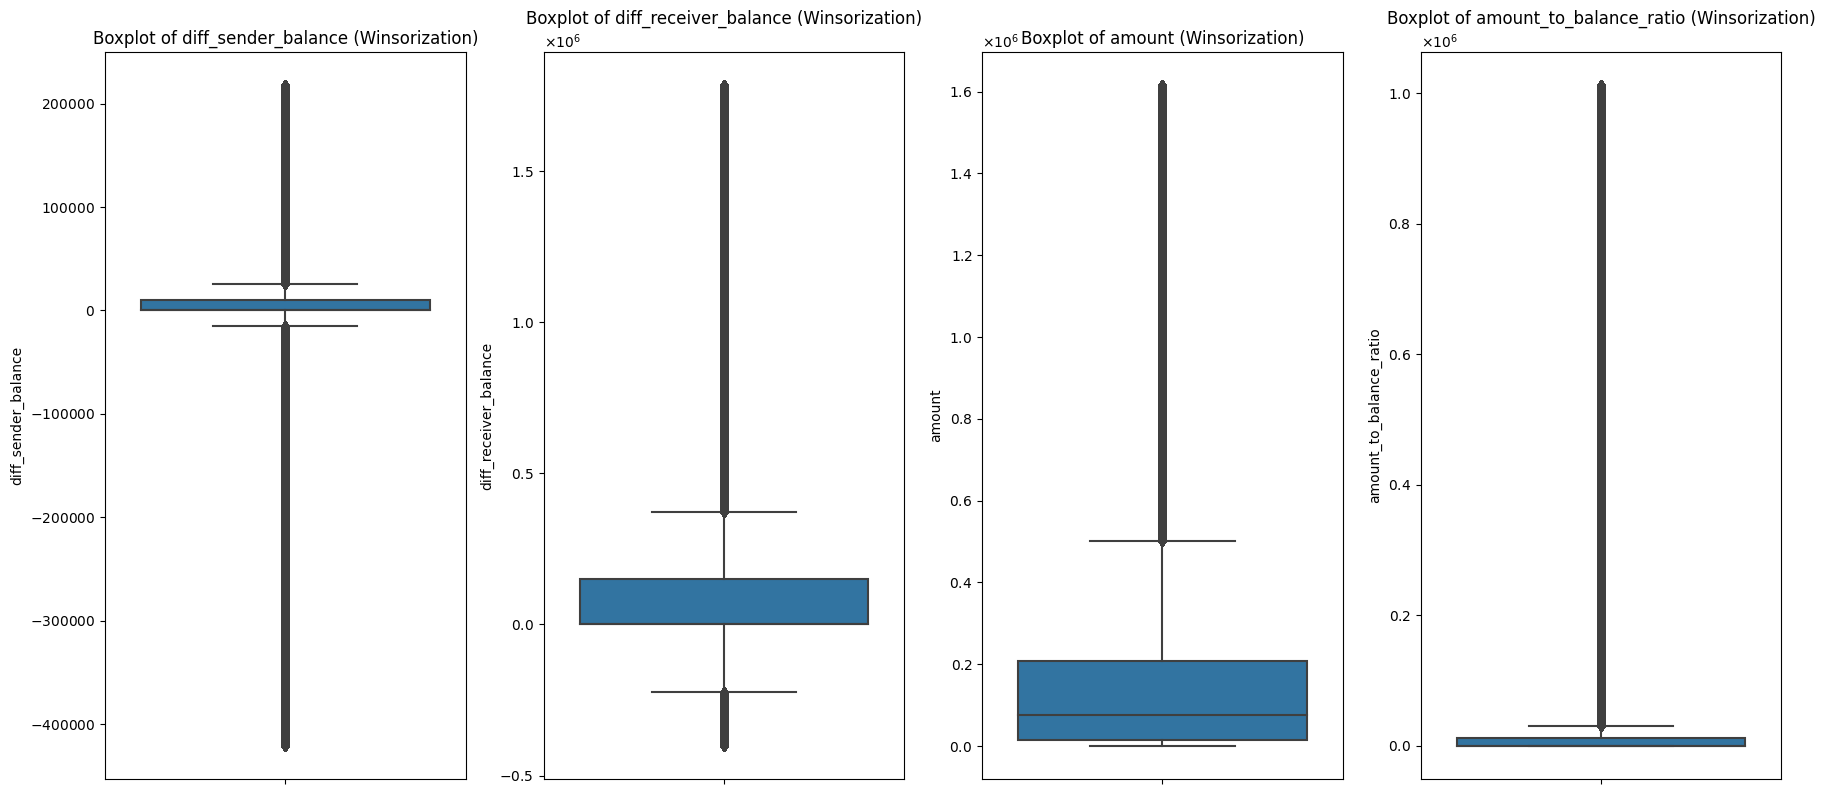

In [ ]:
# Graphic size setting
plt.figure(figsize=(18, 8))

# Boxplots for every selected numerical feature after Winsorization process
for i, col in enumerate(winsorize_features):
    plt.subplot(1, len(winsorize_features), i+1)
    sns.boxplot(y=df_winsorized[col])
    plt.title(f'Boxplot of {col} (Winsorization)')

plt.tight_layout()
for ax in plt.gcf().get_axes():
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.show()

**I have decided not to drop any outliers for now, because they may represent fraudulent behavior**, which are inherently anomalous. Removing outliers could reduce the model’s ability to detect rare but significant fraud patterns.

Before I proceed to the next step, these are the information that I got from my data exploration,

1. `nameOrg` and `nameDest` are unique identifiers and must be dropped because they do not provide any predictive patterns for modeling and may introduce overfitting.

2. Some features like`oldbalanceOrg`, `newbalanceOrg`, `oldbalanceDest`, and `newbalanceDest` are not used due to risk of data leakage and could unintentionally reveal the target label **(isFraud)**.

3. `CASH_OUT` and `PAYMENT` is the two most frequent types of transaction, together comprising 68.98% of total transactions.

4. The typical `amount` involved in fraudulent transactions is significantly higher compared to legitimate ones. The value distributional pattern remains although the outliers were clipped.

5. The `step` feature shows that fraudulent transactions tend to occur more frequently in the second half of the simulation period, indicating a possible time-based pattern in fraudulent behavior.

6. `isFlaggedFraud` is not a reliable indicator to detect fraud because most of the values are 0 (legitimate). It only managed to flag a very small number of fraud transactions.

7. No single feature alone is sufficient to identify fraud.

## IV. DATA MANIPULATION

In this part, I'm going to use `RobustScaler` to standardize the `Numerical Features` of the dataset.

The remaning `Categorical Features` as following won't be scaled.
- isFraud (target variable).
- isFlaggedFraud (binary).
- type (encoded categorical feature).
- sender_is_drained (binary).
- sender_is_zero (binary).
- step (time indicator, an ordinal feature).

Why I decided to use `RobustScaler` instead of `StandardScaler`? Because `StandardScaler` is very sensitive to outliers and the data distribution is skewed.

In [ ]:
# Separation of features before standardization process
features_to_scale = [
    'diff_sender_balance',
    'diff_receiver_balance',
    'amount',
    'amount_to_balance_ratio'
]

features_not_scaled = [
    'isFlaggedFraud',
    'sender_is_drained',
    'sender_is_zero',
    'receiver_is_zero',
    'type',
    'step'
]

In [ ]:
# Initiating RobustScaler
scaler = RobustScaler()

# Fit and transform
df_scaled = df_clean.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df_clean[features_to_scale])

# Preview the results
df_scaled[features_to_scale].describe()

,diff_sender_balance,diff_receiver_balance,amount,amount_to_balance_ratio
count,6362620.0000,6362620.0000,6362620.0000,6362620.0000
mean,-2.0916,0.8336,0.5375,5.7512
std,14.4470,5.4521,3.0914,41.3773
min,-188.6883,-87.5946,-0.3833,-0.0005
25%,0.0000,0.0000,-0.3148,-0.0005
50%,0.0000,0.0000,0.0000,0.0000
75%,1.0000,1.0000,0.6852,0.9995
max,985.1795,708.8128,472.8907,7523.5223


In [ ]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   step                     int64  
 1   type                     int8   
 2   amount                   float64
 3   isFraud                  int64  
 4   isFlaggedFraud           int64  
 5   diff_sender_balance      float64
 6   diff_receiver_balance    float64
 7   sender_is_zero           int64  
 8   receiver_is_zero         int64  
 9   sender_is_drained        int64  
 10  amount_to_balance_ratio  float64
dtypes: float64(4), int64(6), int8(1)
memory usage: 491.5 MB


## V. MODELLING PREPARATION (part 1)

In this part, I'm going to separate X and y variables, **apply SMOTE** on TRAIN set only, directly **tuning** the TRAIN set with **Optuna**, and train the model with **XGBoost method**.

In [ ]:
# 1.  Separate remaining features and target variable
X = df_scaled.drop(columns='isFraud')
y = df_scaled['isFraud']

# 2. Split the data using stratification to preserve fraud distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
# 3. Apply SMOTE to balance the TRAIN set ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print("Before SMOTE:", y_train.value_counts())
print("\nAfter SMOTE:", y_train_smote.value_counts())

Before SMOTE: isFraud
0    5083526
1       6570
Name: count, dtype: int64

After SMOTE: isFraud
0    5083526
1    5083526
Name: count, dtype: int64


**SMOTE sucessfully balanced the TRAIN set by producing synthetic (artificial) 5+ million fraudulent values.**

In [ ]:
model_results = {}

In [ ]:
# Create a function to extract evaluation metrics from each trained model
def get_model_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    return [precision, recall, f1, roc_auc, pr_auc]

# The function above is only run once before the 1st model training
# It doesn't need to be run on every model training session
# It allows the notebook to save model evaluation to be evaluated later

In [ ]:
# 4. Define the Optuna objective function for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 50, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "tree_method": "hist",
        "n_jobs":-1
    }

    # Subsampling for faster Optuna iteration
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, valid_idx in sss.split(X_train_smote, y_train_smote):
        X_tr, X_val = X_train_smote.iloc[train_idx], X_train_smote.iloc[valid_idx]
        y_tr, y_val = y_train_smote.iloc[train_idx], y_train_smote.iloc[valid_idx]

    model = XGBClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=20,
        callbacks=[XGBoostPruningCallback(trial, "validation_0-logloss")],
        verbose=False
    )

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
# 5. Start the Optuna study to optimize the model
start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800)
end = time.time()
print(f"Optuna tuning on XGBoost took: {(end - start):.2f} seconds...")

[I 2025-06-20 01:54:00,242] A new study created in memory with name: no-name-edbc21cb-282b-42a1-9740-9ffd68583109
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-06-20 01:55:26,163] Trial 0 finished with value: 0.9994201198725051 and parameters: {'n_estimators': 81, 'max_depth': 80, 'learning_rate': 0.16917102028671827, 'subsample': 0.7949324219753724, 'colsample_bytree': 0.8817806485014532, 'gamma': 1.9686641670584422, 'reg_lambda': 8.708933742336596, 'reg_alpha': 3.124680016316498}. Best is trial 0 with value: 0.9994201198725051.
/usr/loc

Optuna tuning on XGBoost took: 1905.15 seconds...


In [ ]:
joblib.dump(study, "optuna_study_xgboost.pkl")
print("Optuna study saved successfully as 'optuna_study_xgboost.pkl'")

Optuna study saved successfully as 'optuna_study_xgboost.pkl'


In [ ]:
# 6. Train the final XGBoost model using best parameters
best_params = study.best_params
best_params["random_state"] = 42
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

start_time = time.time()

xgb_smote_optuna_model = XGBClassifier(**best_params)
xgb_smote_optuna_model.fit(X_train_smote, y_train_smote)

end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

# Save evaluation result into a dictionary
scores = get_model_scores(xgb_smote_optuna_model, X_test, y_test)
model_results["XGB+SMOTE+Optuna"] = scores

Training time: 68.54 seconds


## VI. MODELLING EVALUATION (part 1)

In [ ]:
# 7. Evaluate XGBoost + Smote + Optuna model on the original test set
y_pred = xgb_smote_optuna_model.predict(X_test)
y_proba = xgb_smote_optuna_model.predict_proba(X_test)[:, 1]

print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test, y_proba))
print('PR-AUC Score:', average_precision_score(y_test, y_proba))

Confusion Matrix:
 [[1270610     271]
 [      4    1639]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.86      1.00      0.92      1643

    accuracy                           1.00   1272524
   macro avg       0.93      1.00      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9997392114420061
PR-AUC Score: 0.997717474531374


**i. Confusion Matrix**
1. True Negatives (TN) = 1,270,610
2. False Positives (FP) = 271
3. False Negatives (FN) = 4
4. True Positives (TP) = 1,639

**ii. Classification Report for Fraud (1) detection**
1. Precision = 0.86
2. Recall = 1.00
3. F1-score = 0.92
4. Accuracy = 1.00

iii. **ROC-AUC** score is 0.9997.

iv. **PR-AUC** score is 0.9977.

## VII. MODELLING PREPARATION (part 2)

In the second part, I'm going to separate X and y variables, **apply SMOTE** on TRAIN set only, directly **tuning** the TRAIN set with **Optuna**, and train the model with **LightGBM method**.

In [ ]:
# 1.  Separate remaining features and target variable
X = df_scaled.drop(columns='isFraud')
y = df_scaled['isFraud']

# 2. Split the data using stratification to preserve fraud distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
# 3. Apply SMOTE to balance the TRAIN set ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("\nAfter SMOTE:", y_train_smote.value_counts())

Before SMOTE: isFraud
0    5083526
1       6570
Name: count, dtype: int64

After SMOTE: isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [ ]:
# 4. Define the Optuna objective function for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 50, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10),
        "random_state": 42,
        "n_jobs":-1
    }

    # Subsampling for faster Optuna iteration
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, valid_idx in sss.split(X_train_smote, y_train_smote):
        X_tr, X_val = X_train_smote.iloc[train_idx], X_train_smote.iloc[valid_idx]
        y_tr, y_val = y_train_smote.iloc[train_idx], y_train_smote.iloc[valid_idx]

    model = LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[
            LightGBMPruningCallback(trial, "auc"),
            early_stopping(stopping_rounds=20)
    ])

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
# 5. Start the Optuna study to optimize the model
start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800)
end = time.time()
print(f"Optuna tuning on LightGBM took: {(end - start):.2f} seconds...")

[I 2025-06-20 02:27:20,508] A new study created in memory with name: no-name-973420d8-e698-4287-8063-70f7e8480174


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:29:53,169] Trial 0 finished with value: 0.9984915993840314 and parameters: {'n_estimators': 143, 'max_depth': 65, 'learning_rate': 0.01672517910243207, 'num_leaves': 248, 'min_child_samples': 55, 'min_split_gain': 0.13576571664826975, 'subsample': 0.8917409886354115, 'colsample_bytree': 0.647312911320561, 'reg_alpha': 8.23108313969057, 'reg_lambda': 9.172887279025723}. Best is trial 0 with value: 0.9984915993840314.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.251690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.99996	valid_0's binary_logloss: 0.0225893


[I 2025-06-20 02:31:13,566] Trial 1 finished with value: 0.9988962678888785 and parameters: {'n_estimators': 88, 'max_depth': 94, 'learning_rate': 0.03894969137338292, 'num_leaves': 63, 'min_child_samples': 39, 'min_split_gain': 0.38056344254722785, 'subsample': 0.9831566389406565, 'colsample_bytree': 0.7118999179135201, 'reg_alpha': 1.513996065419181, 'reg_lambda': 1.6441763803723048}. Best is trial 1 with value: 0.9988962678888785.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:32:25,760] Trial 2 finished with value: 0.9993482388837336 and parameters: {'n_estimators': 77, 'max_depth': 65, 'learning_rate': 0.09873556463314456, 'num_leaves': 216, 'min_child_samples': 15, 'min_split_gain': 0.45922719059759387, 'subsample': 0.9538222608497817, 'colsample_bytree': 0.9223471193102158, 'reg_alpha': 6.915394520574492, 'reg_lambda': 7.413581392312128}. Best is trial 2 with value: 0.9993482388837336.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:33:29,377] Trial 3 finished with value: 0.9990670977552265 and parameters: {'n_estimators': 57, 'max_depth': 93, 'learning_rate': 0.05789731268953741, 'num_leaves': 180, 'min_child_samples': 84, 'min_split_gain': 0.6972120471814016, 'subsample': 0.7939091307770462, 'colsample_bytree': 0.7167038226143616, 'reg_alpha': 1.1963603558159701, 'reg_lambda': 4.081104369312613}. Best is trial 2 with value: 0.9993482388837336.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.801653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.999851	valid_0's binary_logloss: 0.0570303


[I 2025-06-20 02:34:50,231] Trial 4 finished with value: 0.9981919858170237 and parameters: {'n_estimators': 94, 'max_depth': 58, 'learning_rate': 0.025711834267429116, 'num_leaves': 31, 'min_child_samples': 99, 'min_split_gain': 0.4631709346189872, 'subsample': 0.9730017826227146, 'colsample_bytree': 0.6758971841312926, 'reg_alpha': 1.041679136340604, 'reg_lambda': 9.444855342478833}. Best is trial 2 with value: 0.9993482388837336.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:36:19,545] Trial 5 finished with value: 0.9993091974488196 and parameters: {'n_estimators': 108, 'max_depth': 70, 'learning_rate': 0.04639178666857986, 'num_leaves': 200, 'min_child_samples': 45, 'min_split_gain': 0.5469235675589038, 'subsample': 0.8890443365310725, 'colsample_bytree': 0.9773063535745933, 'reg_alpha': 3.240691759904952, 'reg_lambda': 5.470684056280754}. Best is trial 2 with value: 0.9993482388837336.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.286072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:38:07,972] Trial 6 finished with value: 0.9993994510109788 and parameters: {'n_estimators': 139, 'max_depth': 67, 'learning_rate': 0.09904497132277264, 'num_leaves': 215, 'min_child_samples': 69, 'min_split_gain': 0.7153760258457692, 'subsample': 0.8331986427054812, 'colsample_bytree': 0.9553933292542096, 'reg_alpha': 0.40135593729940433, 'reg_lambda': 6.658973868854492}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:38:19,643] Trial 7 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.386595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:38:32,384] Trial 8 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:38:45,238] Trial 9 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:40:51,785] Trial 10 finished with value: 0.999334117522025 and parameters: {'n_estimators': 148, 'max_depth': 78, 'learning_rate': 0.0749255061882661, 'num_leaves': 255, 'min_child_samples': 75, 'min_split_gain': 0.8298413146948482, 'subsample': 0.7214274145321835, 'colsample_bytree': 0.8673633568646932, 'reg_alpha': 9.77715821500989, 'reg_lambda': 3.4840916419131416}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:41:09,068] Trial 11 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:42:49,256] Trial 12 finished with value: 0.9993613572945166 and parameters: {'n_estimators': 118, 'max_depth': 60, 'learning_rate': 0.08212507236850312, 'num_leaves': 171, 'min_child_samples': 31, 'min_split_gain': 0.7950824223952947, 'subsample': 0.8611781105959156, 'colsample_bytree': 0.8945286854317331, 'reg_alpha': 6.654598094651981, 'reg_lambda': 7.639227969696629}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:44:32,986] Trial 13 finished with value: 0.9993823675952582 and parameters: {'n_estimators': 127, 'max_depth': 50, 'learning_rate': 0.07856949942682474, 'num_leaves': 169, 'min_child_samples': 30, 'min_split_gain': 0.8269905481610178, 'subsample': 0.8307853329876763, 'colsample_bytree': 0.8659279512314114, 'reg_alpha': 3.0036086711498746, 'reg_lambda': 7.348716060049538}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:44:44,192] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:46:36,287] Trial 15 finished with value: 0.9993758091438877 and parameters: {'n_estimators': 137, 'max_depth': 84, 'learning_rate': 0.08751356766053342, 'num_leaves': 162, 'min_child_samples': 69, 'min_split_gain': 0.8724695680868938, 'subsample': 0.7512842473363003, 'colsample_bytree': 0.9359211316705005, 'reg_alpha': 2.8142156395431517, 'reg_lambda': 4.087683311298667}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.227337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:46:47,512] Trial 16 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.224470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:46:59,147] Trial 17 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:48:32,686] Trial 18 finished with value: 0.9993813890603608 and parameters: {'n_estimators': 107, 'max_depth': 72, 'learning_rate': 0.0867434620331275, 'num_leaves': 240, 'min_child_samples': 44, 'min_split_gain': 0.598895346496092, 'subsample': 0.9349323885938281, 'colsample_bytree': 0.9290407574087585, 'reg_alpha': 4.61221796201481, 'reg_lambda': 7.166723511738138}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.346263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:49:31,735] Trial 19 pruned. Trial was pruned at iteration 71.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:49:43,624] Trial 20 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:49:56,865] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:51:25,908] Trial 22 finished with value: 0.9993721963680543 and parameters: {'n_estimators': 103, 'max_depth': 74, 'learning_rate': 0.09010638164138243, 'num_leaves': 235, 'min_child_samples': 50, 'min_split_gain': 0.640422083850877, 'subsample': 0.9179859521471073, 'colsample_bytree': 0.9038428893841736, 'reg_alpha': 4.827302228589643, 'reg_lambda': 6.528090773682395}. Best is trial 6 with value: 0.9993994510109788.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:51:37,595] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:51:53,457] Trial 24 pruned. Trial was pruned at iteration 7.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:52:06,125] Trial 25 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:52:22,432] Trial 26 pruned. Trial was pruned at iteration 8.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:52:53,257] Trial 27 pruned. Trial was pruned at iteration 31.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.238599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:53:04,921] Trial 28 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.248263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:53:16,927] Trial 29 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:53:29,285] Trial 30 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:54:46,573] Trial 31 pruned. Trial was pruned at iteration 94.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-06-20 02:55:57,896] Trial 32 pruned. Trial was pruned at iteration 88.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.248596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:56:14,713] Trial 33 pruned. Trial was pruned at iteration 7.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-06-20 02:57:06,833] Trial 34 pruned. Trial was pruned at iteration 63.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.335795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:57:18,665] Trial 35 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 3558468, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 7116936, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-20 02:57:30,088] Trial 36 pruned. Trial was pruned at iteration 0.


Optuna tuning on LightGBM took: 1809.58 seconds...


In [ ]:
joblib.dump(study, "optuna_study_lightgbm.pkl")
print("Optuna study saved successfully as 'optuna_study_lightgbm.pkl'")

Optuna study saved successfully as 'optuna_study_lightgbm.pkl'


In [ ]:
# 6. Train the final LightGBM model using best parameters
best_params = study.best_params
best_params["random_state"] = 42

start_time = time.time()

lightgbm_smote_optuna_model = LGBMClassifier(**best_params)
lightgbm_smote_optuna_model.fit(X_train_smote, y_train_smote, eval_metric="logloss")

end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

# Save evaluation result info a dictionary
scores = get_model_scores(lightgbm_smote_optuna_model, X_test, y_test)
model_results["LightGBM+SMOTE+Optuna"] = scores

[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.397128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

## VIII. MODELLING EVALUATION (part 2)

In [ ]:
# 7. Evaluate LightGBM Smote Optuna model on the original test set
y_pred = lightgbm_smote_optuna_model.predict(X_test)
y_proba = lightgbm_smote_optuna_model.predict_proba(X_test)[:, 1]

print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test, y_proba))
print('PR-AUC Score:', average_precision_score(y_test, y_proba))

Confusion Matrix:
 [[1270675     206]
 [      4    1639]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.89      1.00      0.94      1643

    accuracy                           1.00   1272524
   macro avg       0.94      1.00      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9998832867380405
PR-AUC Score: 0.9976789983463182


**i. Confusion Matrix**
1. True Negatives (TN) = 1,270,675
2. False Positives (FP) = 206
3. False Negatives (FN) = 4
4. True Positives (TP) = 1,639

**ii. Classification Report for Fraud (1) detection**
1. Precision = 0.89
2. Recall = 1.00
3. F1-score = 0.94
4. Accuracy = 1.00

iii. **ROC-AUC** score is 0.9999.

iv. **PR-AUC** score is 0.9977.

## IX. MODELLING PREPARATION (part 3)

In the third part, I'm going to separate X and y variables, **apply SMOTE** on TRAIN set only, directly **tuning** the TRAIN set with **Optuna**, and train the model with **CatBoost method**.

In [ ]:
# 1. Split the features (X) and the target variable (y)
X = df_scaled.drop(columns='isFraud')
y = df_scaled['isFraud']

In [ ]:
# 2. Split the dataset into TRAIN and TEST sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
# 3. Apply SMOTE to TRAINING set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_smote.value_counts())

Before SMOTE:
 isFraud
0    5083526
1       6570
Name: count, dtype: int64

After SMOTE:
 isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [ ]:
# 4. Define Optuna objective function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_state": 42,
        "verbose": 0,
        "thread_count":-1
    }

    # Subsampling for faster Optuna iteration
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, valid_idx in sss.split(X_train_smote, y_train_smote):
        X_tr, X_val = X_train_smote.iloc[train_idx], X_train_smote.iloc[valid_idx]
        y_tr, y_val = y_train_smote.iloc[train_idx], y_train_smote.iloc[valid_idx]

    model = CatBoostClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=20,
        verbose=0,
        callbacks=[CatBoostPruningCallback(trial, "Logloss")]
    )

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
# 5. Run the Optuna study to find the best hyperparameters
start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800)
end = time.time()
print(f"Optuna tuning on CatBoost took: {(end - start):.2f} seconds...")

[I 2025-06-20 02:59:25,711] A new study created in memory with name: no-name-4c1c45c3-17be-4907-b09f-c0350e880db7
/tmp/ipykernel_35/641059176.py:27: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks=[CatBoostPruningCallback(trial, "Logloss")]
[I 2025-06-20 03:05:20,194] Trial 0 finished with value: 0.9993941988057812 and parameters: {'iterations': 144, 'max_depth': 16, 'learning_rate': 0.25149712688817566, 'l2_leaf_reg': 3.9495527424596704, 'bagging_temperature': 0.2510883457788431, 'border_count': 185}. Best is trial 0 with value: 0.9993941988057812.
/tmp/ipykernel_35/641059176.py:27: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks=[CatBoostPruningCallback(trial, "Logloss")]
[I 2025-06-20 03:07:40,767] Trial 1 finished with value: 0.9992901790165896 and parameters: {'iterations': 150, 'max_depth': 11, 'learnin

Optuna tuning on CatBoost took: 1801.28 seconds...


In [ ]:
joblib.dump(study, "optuna_study_catboost.pkl")
print("Optuna study saved successfully as 'optuna_study_catboost.pkl'")

Optuna study saved successfully as 'optuna_study_catboost.pkl'


In [ ]:
# 6. Train final CatBoost model with the best parameters
best_params = study.best_params
best_params["random_state"] = 42
best_params["verbose"] = 0

start_time = time.time()

catboost_smote_optuna_model = CatBoostClassifier(**best_params)
catboost_smote_optuna_model.fit(X_train_smote, y_train_smote)

end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

# Save evaluation result info a dictionary
scores = get_model_scores(catboost_smote_optuna_model, X_test, y_test)
model_results["CatBoost+SMOTE+Optuna"] = scores

Training time: 509.99 seconds


## X. MODELLING EVALUATION (part 3)

In [ ]:
# 7. Evaluate the model on the test set
y_pred = catboost_smote_optuna_model.predict(X_test)
y_proba = catboost_smote_optuna_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("PR-AUC Score:", average_precision_score(y_test, y_proba))

Confusion Matrix:
 [[1270631     250]
 [      4    1639]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.87      1.00      0.93      1643

    accuracy                           1.00   1272524
   macro avg       0.93      1.00      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.9998743525970257
PR-AUC Score: 0.99762641785715


**i. Confusion Matrix**
1. True Negatives (TN) = 1,270,631
2. False Positives (FP) = 250
3. False Negatives (FN) = 4
4. True Positives (TP) = 1,639

**ii. Classification Report for Fraud (1) detection**
1. Precision = 0.87
2. Recall = 1.00
3. F1-score = 0.93
4. Accuracy = 1.00

iii. **ROC-AUC** score is 0.9999.

iv. **PR-AUC** score is 0.9976.

## XI. MODEL COMPARISON & SELECTION

I managed to train 3 kinds of machine learning model to detect fraud transactions in the previous sections as following,
1. xgb_smote_optuna_model **(XGBoost+SMOTE+Optuna)**.
2. lightgbm_smote_optuna_model **(LightGBM+SMOTE+Optuna)**.
3. catboost_smote_optuna_model **(CatBoost+SMOTE+Optuna)**.

Based on Confusion Matrix, Classification Report, ROC-AUC, and PR-AUC scores in the previous sections, the best machine learning model is **lightgbm_smote_optuna_model (LightGBM+SMOTE+Optuna)**.

**LightGBM + SMOTE + Optuna** model is the best performing model overall, showing the highest balance of Precision, Recall, and F1-Score, while maintaining excellent ROC-AUC and PR-AUC scores.

 I'm going to use a grouped bar chart to visualize each model's evaluation scores in detecting fraudulent transactions.

In [ ]:
# 1. Dictionary to define model names
models = {
    "XGBoost + SMOTE + Optuna": xgb_smote_optuna_model,
    "LightGBM + SMOTE + Optuna": lightgbm_smote_optuna_model,
    "CatBoost + SMOTE + Optuna": catboost_smote_optuna_model
}

In [ ]:
# 2. Function for model evaluation visualization
def plot_grouped_bar_chart(model_results):
    labels = ["PRECISION", "RECALL", "F1-SCORE", "ROC-AUC", "PR-AUC"]

    x = np.arange(len(labels))
    width = 0.25
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = ['yellow', 'skyblue', 'red']
    for i, (model_name, color) in enumerate(zip(model_results.keys(), colors)):
        scores = model_results[model_name]
        bars = ax.bar(x + i * width, scores, width, label=model_name, color=color)

        # Display score values on top of each bar
        for bar in bars:
            height = bar.get_height()
            offset = 0.002
            ax.text(bar.get_x() + bar.get_width() / 2, height + offset, f"{height:.4f}", ha='center', fontsize=10)

    ax.set_ylabel('SCORE')
    ax.set_title('ML Model Evaluation Metrics Comparison in Fraud Detection (Class 1)')
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels)

    # Set Y-axis limits to be proportional and stable
    all_scores = [score for scores in model_results.values() for score in scores]
    ymin = 0.0
    ymax = min(1.01, max(all_scores) + 0.01)
    ax.set_ylim(0.0, 1.05)

    # Display legend in the bottom right corner
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

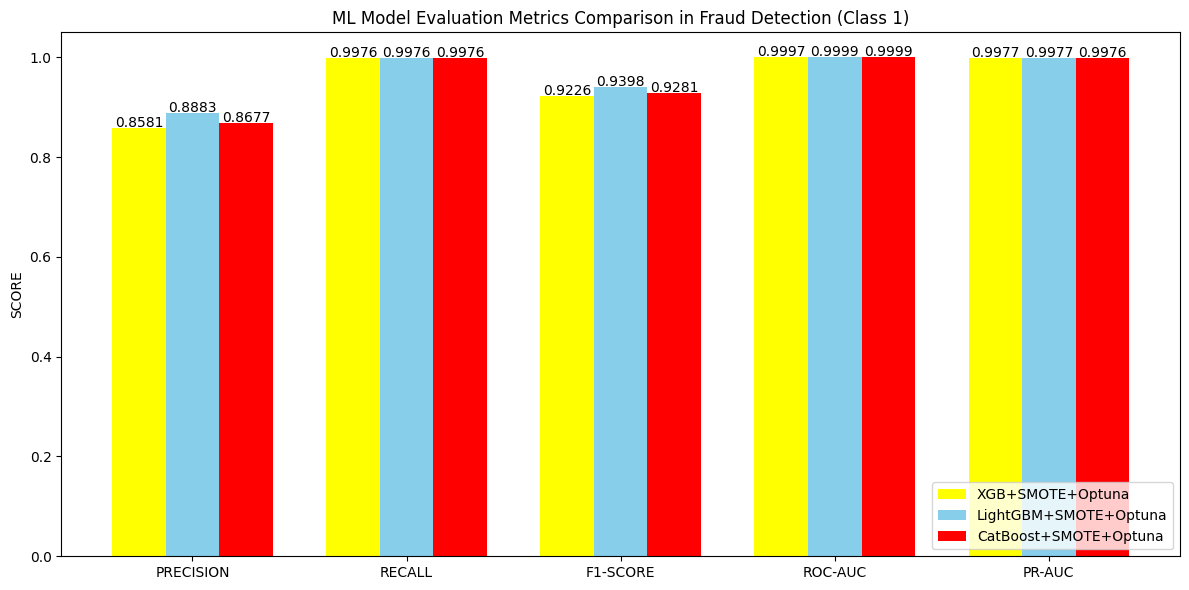

,XGB+SMOTE+Optuna,LightGBM+SMOTE+Optuna,CatBoost+SMOTE+Optuna
Precision,0.8581,0.8883,0.8677
Recall,0.9976,0.9976,0.9976
F1-Score,0.9226,0.9398,0.9281
ROC-AUC,0.9997,0.9999,0.9999
PR-AUC,0.9977,0.9977,0.9976


In [ ]:
# 3. Run the Visualization Function
plot_grouped_bar_chart(model_results)

# 4. Convert dictionary to DataFrame for visualization in table format
df_results = pd.DataFrame(model_results, index=["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"])
display(df_results)

### i. ROC Curve Analysis for XGBoost + SMOTE + Optuna ML Model

The **ROC (Receiver Operating Characteristic)** curve plots the **True Positive (TP) Rate (Recall)** against the **False Positive (FP) Rate** at various classification thresholds.

It helps evaluate how well the model distinguishes between Fraudulent and Legitimate transactions. The **Area Under the Curve (AUC) score** summarizes this ability in a single number, the closer to 1.0, the better the model is at differentiating Legitimate from Fraudulent transactions.

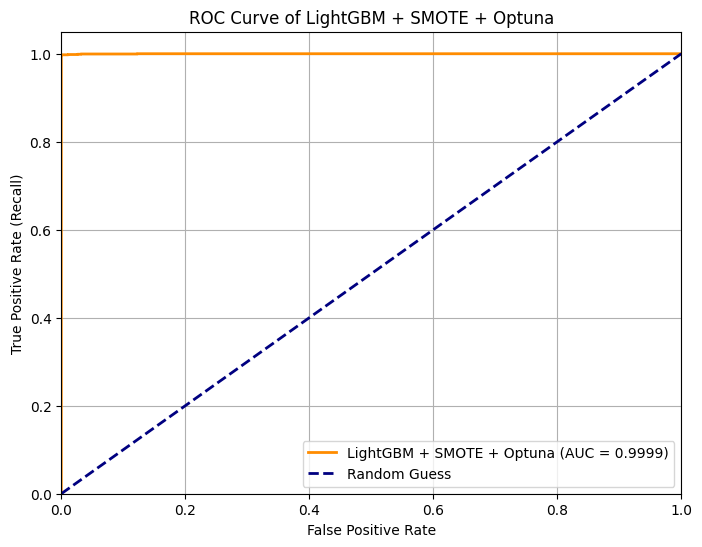

In [ ]:
# Predict probabilities for class 1 (Fraud)
y_proba = lightgbm_smote_optuna_model.predict_proba(X_test)[:, 1]

# Compute ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f"LightGBM + SMOTE + Optuna (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve of LightGBM + SMOTE + Optuna")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**ROC-AUC Score Interpretation**

Score Range	      Interpretation

0.90 - 1.00	-->   Excellent / Outstanding

0.80 - 0.90	-->   Very Good

0.70 - 0.80	-->   Good

0.60 - 0.70	-->   Fair

0.50 - 0.60	-->   Poor

< 0.50	    -->   Failing

The **LightGBM + SMOTE + Optuna model** demonstrates outstanding discrimination ability with an AUC score of 0.9999. This model is extremely effective at distinguishing Fraudulent transactions from Legitimate ones, even under severe class imbalance.

### ii. PR Curve Analysis for CatBoost + SMOTE + Optuna ML Model

The **Precision Recall (PR)** curve is a visualization used to evaluate the performance of a classification machine learning model, especially when dealing with imbalanced datasets. It plots **Precision vs Recall**, it helps to understand the trade-off between catching more **Frauds (High Recall)** and avoiding **false alarms (High Precision)**.

- Precision --> the **proportion** of **true frauds** among all flagged transactions.

- Recall --> the **proportion** of **actual frauds** the model successfully detects.

A high PR curve indicates that the model is effective at identifying **positive cases (Frauds)** without producing too many False Positives (FP).

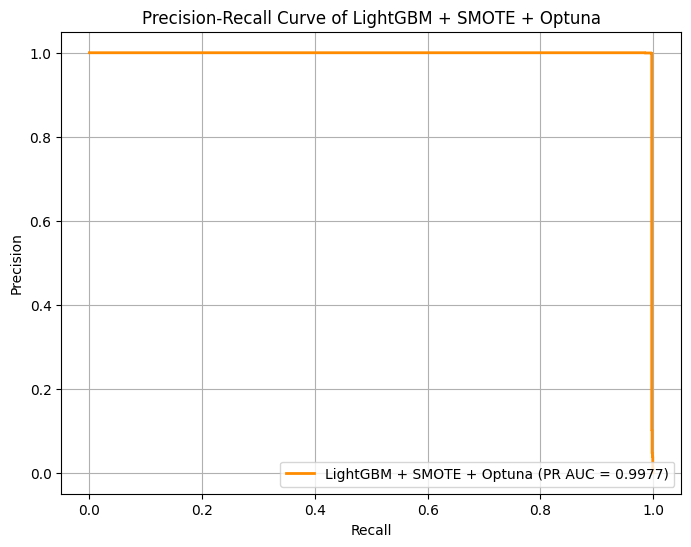

In [ ]:
# Predict probability for class 1 (Fraud)
y_proba = lightgbm_smote_optuna_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_pr_auc = average_precision_score(y_test, y_proba)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="darkorange", lw=2, label=f"LightGBM + SMOTE + Optuna (PR AUC = {avg_pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve of LightGBM + SMOTE + Optuna")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**PR-AUC Score Interpretation**

Score Range	      Interpretation

0.90 - 1.00	-->   Excellent / Outstanding

0.80 - 0.90	-->   Very Good

0.70 - 0.80	-->   Good

0.60 - 0.70	-->   Fair

0.50 - 0.60	-->   Poor

< 0.50	    -->   Failing


The **XGBoost + SMOTE + Optuna model** shows outstanding performance in detecting fraudulent transactions. With a PR-AUC score of 0.9977, the model is highly effective in maintaining both High Precision and High Recall simultaneously. It can accurately identify fraud while minimizing false alarms (False Positives), which is essential in real world applications by reducing operational costs.

## XII. SAVING THE CHOSEN MODEL FOR FUTURE TEST & USE

In [ ]:
# 1. Save the chosen trained model
# Save the chosen LightGBM + SMOTE + Optuna model
joblib.dump(lightgbm_smote_optuna_model, 'lightgbm_smote_optuna_model.pkl')
print("The model has been successfully saved as 'lightgbm_smote_optuna_model.pkl'")

The model has been successfully saved as 'lightgbm_smote_optuna_model.pkl'


Alright, now let's give it a try by applying the chosen & saved model into randomly generated dataset.

In [ ]:
# 2. Load & apply the saved chosen model to random test data

# Load the saved model
lightgbm_loaded = joblib.load('lightgbm_smote_optuna_model.pkl')

# Get the number of features from X_test (must be consistent with training)
num_features = X_test.shape[1]  # Ensure X_test is already defined

# Generate 5 random samples for testing (values between 0 and 1)
random_data = np.random.rand(5, num_features)

# Convert to DataFrame with the same column names as X_test
df_random_test = pd.DataFrame(random_data, columns=X_test.columns)

# Display the generated random transactions
print("\nSample Random Test Transactions:")
display(df_random_test)


Sample Random Test Transactions:


,step,type,amount,isFlaggedFraud,diff_sender_balance,diff_receiver_balance,sender_is_zero,receiver_is_zero,sender_is_drained,amount_to_balance_ratio
0,0.342316,0.118738,0.620134,0.756938,0.122732,0.126468,0.041461,0.093275,0.193266,0.442392
1,0.939222,0.214844,0.665500,0.275782,0.100749,0.915468,0.696151,0.423023,0.512131,0.021957
2,0.627363,0.037060,0.708933,0.207728,0.999161,0.717480,0.780580,0.522765,0.470347,0.967700
3,0.378928,0.071178,0.376811,0.232691,0.336937,0.240101,0.989716,0.085357,0.278114,0.459039
4,0.545933,0.351636,0.649004,0.721769,0.952705,0.240761,0.459947,0.981497,0.377023,0.911897


In [ ]:
# Predict fraud class (0 = normal, 1 = fraud)
predicted_class = lightgbm_loaded.predict(df_random_test)

# Predict fraud probability (class 1)
predicted_proba = lightgbm_loaded.predict_proba(df_random_test)[:, 1]

# Combine predictions with the original random data
df_random_test['Predicted_Class'] = predicted_class
df_random_test['Fraud_Probability'] = predicted_proba

# Format float output
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Show the final prediction DataFrame
print("\nPrediction Results:")
display(df_random_test)

# Show formatted prediction summary for each transaction
print("\nDetailed Predictions:")
for i, row in df_random_test.iterrows():
    label = "FRAUD" if row['Predicted_Class'] == 1 else "LEGITIMATE"
    prob = row['Fraud_Probability']
    print(f"Transaction {i+1}: Predicted as {label} (Fraud Probability: {prob:.6f})")


Prediction Results:


,step,type,amount,isFlaggedFraud,diff_sender_balance,diff_receiver_balance,sender_is_zero,receiver_is_zero,sender_is_drained,amount_to_balance_ratio,Predicted_Class,Fraud_Probability
0,0.342316,0.118738,0.620134,0.756938,0.122732,0.126468,0.041461,0.093275,0.193266,0.442392,0,0.165703
1,0.939222,0.214844,0.665500,0.275782,0.100749,0.915468,0.696151,0.423023,0.512131,0.021957,0,0.046653
2,0.627363,0.037060,0.708933,0.207728,0.999161,0.717480,0.780580,0.522765,0.470347,0.967700,1,0.908080
3,0.378928,0.071178,0.376811,0.232691,0.336937,0.240101,0.989716,0.085357,0.278114,0.459039,0,0.259189
4,0.545933,0.351636,0.649004,0.721769,0.952705,0.240761,0.459947,0.981497,0.377023,0.911897,1,0.921915



Detailed Predictions:
Transaction 1: Predicted as LEGITIMATE (Fraud Probability: 0.165703)
Transaction 2: Predicted as LEGITIMATE (Fraud Probability: 0.046653)
Transaction 3: Predicted as FRAUD (Fraud Probability: 0.908080)
Transaction 4: Predicted as LEGITIMATE (Fraud Probability: 0.259189)
Transaction 5: Predicted as FRAUD (Fraud Probability: 0.921915)


## XIII. KEY STEPS TAKEN

1. **Data Loading**: Imported and inspected the PaySim dataset simulating mobile transactions.
2. **Exploratory Data Analysis (EDA)**: Conducted initial visualizations and summaries to understand data (values) distribution and Fraud patterns.
3. **Data Cleaning & Feature Engineering**: Removed any irrelevant features and created meaningful new features (e.g. balance differences).
4. **Handling Imbalanced Data**: Applied SMOTE oversampling to balance Fraud and Legitimate classes.
5. **Model Selection**: Chose and used three ML models (XGBoost, LightGBM, and CatBoost) with Optuna for hyperparameter tuning.
6. **Model Evaluation**: Evaluated three ML models using various metrics such as, Precision, Recall, F1, ROC-AUC, and PR-AUC.
7. **Model Interpretation**: Analyzed ROC and PR Curves to assess Fraud detection performance.
8. **Model Saving & Testing**: Saved the best model, which is LightGBM + SMOTE + Optuna, and tested it on new randomly generated data.

## XIV. EXECUTIVE SUMMARY

This analysis aimed to detect fraudulent financial transactions using a simulated PaySim dataset. The dataset showed severe class imbalance, which was mitigated using SMOTE. Three different machine learning models were trained with hyperparameter tuning via Optuna.

After evaluation using multiple metrics (Precision, Recall, F1-score, ROC-AUC, PR-AUC), the **LightGBM + SMOTE + Optuna** model was selected as the best performing model due to its excellent precision and recall balance.

This model achieved an AUC of **0.9999** and PR-AUC of **0.9977**, proving to be highly reliable for fraud detection use cases. It was then saved and successfully applied to generate predictions for randomly created transactions for testing purpose.